In this notebook, I introduce an adaptive linear neuron with Stochastic Gradient Descent and annealing. I then train and test out how well the neuron classifies two different cultivars of an Iris.   

In [99]:
class AdalineSGDeta(object):
    """Adaptive Perceptron classifier that uses stochastic gradient descent with annealing.
    
    Parameters
    ------------
    eta_0,eta_1 : float
      If anneal = True, learning rate decreases with iterations for annealing as,
          eta = eta_0/((interations)+eta_1)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    shuffle : bool (default = True)
      Shuffles the training data to prevent cycles
      

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list of cost=sum(error^2)/2 in each epoch.
    

    """
    def __init__(self, eta_0=0.1,eta_1=0.5, anneal=True, n_iter=50, random_state=1,shuffle=True):
        
        self.eta = eta_0
        self.eta1 = eta_1
        self.n_iter = n_iter
        self.random_state = random_state
        self.shuffle=shuffle
        self.w_initialized = False
        self.anneal = anneal
       
        
    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.
         
        Attributes
        -------
        cost_ : list
          Sum-of-squares cost function value averaged over all training samples in each epoch.
        w_ : list 
            array of weights after fit
        eta_: number
            final eta after annealing

        Returns
        -------
        self : object

        """
        
        
        self.cost_ = []
        self._initialize_weights(X.shape[1])
        

        for i in range(self.n_iter):
            cost=[]; 
            self._eta_update(i)
            if self.shuffle:
                X,y=self.shuffle_data(X,y)
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi,target))
                
            avg_cost=sum(cost)/len(y)
            self.cost_.append(avg_cost)    
        return self

    def _initialize_weights(self,p): 
        """Initializes random weights and sets self.w_initialized to true"""
        self.rgen = np.random.RandomState(self.random_state)
        #size = w0 + a weight for your n_features of your input
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + p)
        self.w_initialized = True
       
    def _update_weights(self,xi,target):
        """Updates weights based on error for each xi"""
        output = self.activation(self.net_input(xi))
        error = (target-output) 
        self.w_[0] += self.eta*error
        self.w_[1:] += self.eta*error*xi
        cost = 0.5*error**2
        return cost
    
    def _eta_update(self,i):
        if self.anneal:
            if i > 0:
                self.eta=self.eta*(i+(self.eta1-1))/(i+self.eta1)
            else:
                self.eta=self.eta/(self.eta1)
        else: 
            self.eta=self.eta

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def shuffle_data(self,X,y):
        """Shuffles Training Data"""
        r=self.rgen.permutation(len(y))
        return X[r],y[r]
    
    def activation(self, X):
        """Compute linear activation"""
        return X

    def partial_fit(self,X,y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            self.eta=self.eta/self.eta1
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi,target)
        else:
            self._update_weights(X,y) 
        
        return self

    def predict(self, X):
        """Return class label after unit step.  Note: It assumes negative class = -1"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


In [96]:
from matplotlib.colors import ListedColormap


"""This function generates a 2x2 numerical grid of data features and calls the classifier to predict the class (positive or negative) depending on the feature coordinate
The predicted classes "Z" is depicted in color on the contour plot"""

def plot_decision_regions(X, y,classifier, resolution=0.02,Labels=None):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #While you need the grid from the contour plot, you need just x1 and x2 values for your neural network
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    #what enumerate does is associates a number with each unique instance of y
    
    
    for idx, cl in enumerate(np.unique(y)):
        if Labels is None:
            Labels=["Positive","Negative"]
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=Labels[idx], 
                    edgecolor='black')



In [31]:

def rescaler(X):
    #rescales data by mean and standard deviation
    return (X-X.mean())/X.std()



In [84]:


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.cross_validation import train_test_split

iris = datasets.load_iris()
X = iris.data[:, [1, 3]]  #columns 1 and 3 describe the sepal and petal length
y = iris.target


#Our neuron casts the negative class as -1, not zero
y[y==0]=-1

#Rescaling Data
X_scaled =np.copy(X)
    
    
X_scaled[:,0] = rescaler(X_scaled[:,0])    
X_scaled[:,1] = rescaler(X_scaled[:,1])    


X_train, X_test, y_train, y_test = train_test_split(X_scaled[:100], y[:100], test_size=0.20)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(80, 2) (80,)
(20, 2) (20,)


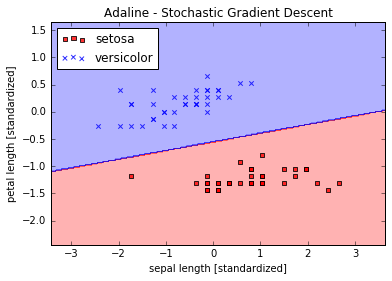

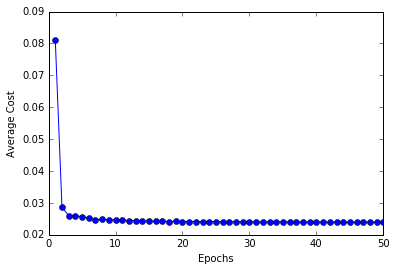

In [97]:
ada = AdalineSGDeta(n_iter=50, eta_0=0.1,eta_1=0.5, random_state=1)
ada.fit(X_train,y_train)

plot_decision_regions(X_train, y_train, Labels=iris.target_names[:2],classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()